In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import random
import numpy as np
import torch


from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
# from src.models.swincspunetr import SwinCSPUNETR
# from src.models.swincspunetr_unet import SwinCSPUNETR_unet
# from src.models.swincspunetr3plus import SwinCSPUNETR3plus

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# 랜덤 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


print_config()

c:\Users\pook0\.conda\envs\UM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\.conda\envs\UM\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.17.2
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.

In [2]:
# class_info = {
#     0: {"name": "background", "weight": 0},  # weight 없음
#     1: {"name": "apo-ferritin", "weight": 1000},
#     2: {"name": "beta-amylase", "weight": 100}, # 4130
#     3: {"name": "beta-galactosidase", "weight": 1500}, #3080
#     4: {"name": "ribosome", "weight": 1000},
#     5: {"name": "thyroglobulin", "weight": 1500},
#     6: {"name": "virus-like-particle", "weight": 1000},
# }

# # 가중치에 비례한 비율 계산
# raw_ratios = {
#     k: (v["weight"] if v["weight"] is not None else 0.01)  # 가중치 비례, None일 경우 기본값a
#     for k, v in class_info.items()
# }
# total = sum(raw_ratios.values())
# ratios = {k: v / total for k, v in raw_ratios.items()}

# # 최종 합계가 1인지 확인
# final_total = sum(ratios.values())
# print("클래스 비율:", ratios)
# print("최종 합계:", final_total)

# # 비율을 리스트로 변환
# ratios_list = [ratios[k] for k in sorted(ratios.keys())]
# print("클래스 비율 리스트:", ratios_list)

# 모델 설정

In [ ]:
from src.dataset.dataset import create_dataloaders, create_dataloaders_bw
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    Orientationd, CropForegroundd, GaussianSmoothd, ScaleIntensityd,
    RandSpatialCropd, RandRotate90d, RandFlipd, RandGaussianNoised,
    ToTensord, RandCropByLabelClassesd, RandCropByPosNegLabeld, RandCropd, RandSpatialCrop,
)
from monai.transforms import CastToTyped
import numpy as np

train_img_dir = "./denoised_datasets/train/images"
train_label_dir = "./denoised_datasets/train/labels"
val_img_dir = "./denoised_datasets/val/images"
val_label_dir = "./denoised_datasets/val/labels"
# DATA CONFIG
img_size =  96 # Match your patch size
img_depth = img_size
n_classes = 1
batch_size = 16 # 13.8GB GPU memory required for 128x128 img size
loader_batch = 1
num_samples = batch_size // loader_batch # 한 이미지에서 뽑을 샘플 수
num_repeat = 10
# MODEL CONFIG
num_epochs = 4000
lamda = 0.5
ce_weight = 0.4
lr = 0.001
feature_size = 48
use_checkpoint = True
use_v2 = True
drop_rate= 0.2
attn_drop_rate = 0.2
num_bottleneck = 2
# CLASS_WEIGHTS
class_weights = None
# class_weights = torch.tensor([0.0001, 1, 0.001, 1.1, 1, 1.1, 1], dtype=torch.float32)  # 클래스별 가중치
sigma = 2.0
accumulation_steps = 1
# INIT
start_epoch = 0
best_val_loss = float('inf')
best_val_fbeta_score = 0

non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
])
val_non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
])
random_transforms = Compose([
    RandCropd(
        keys=["image", "label"],
        cropper=RandSpatialCrop(roi_size=[img_depth, img_size, img_size], random_center=True, random_size=False)
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
])


In [4]:
train_loader, val_loader = None, None
train_loader, val_loader = create_dataloaders(
    train_img_dir, 
    train_label_dir, 
    val_img_dir, 
    val_label_dir, 
    non_random_transforms = non_random_transforms, 
    random_transforms = random_transforms, 
    batch_size = loader_batch,
    num_workers=0,train_num_repeat=num_repeat)

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


https://monai.io/model-zoo.html

In [5]:
from monai.losses import TverskyLoss
import torch
import torch.nn as nn

criterion = nn.MSELoss()  # 또는 nn.L1Loss()

In [ ]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
from pathlib import Path
from monai.networks.nets import UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=n_classes,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=1,
    dropout = drop_rate,
).to(device)

pretrain_str = "yes" if use_checkpoint else "no"
weight_str = "weighted" if class_weights is not None else ""

# 체크포인트 디렉토리 및 파일 설정
checkpoint_base_dir = Path("./model_checkpoints")
folder_name = f"Denoising_UNet5_{weight_str}_f{feature_size}_d{img_depth}s{img_size}_numb{num_bottleneck}_lr{lr:.0e}_a{lamda:.2f}_b{1-lamda:.2f}_b{batch_size}_r{num_repeat}_ce{ce_weight}_ac{accumulation_steps}"
checkpoint_dir = checkpoint_base_dir / folder_name
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
# 체크포인트 디렉토리 생성
checkpoint_dir.mkdir(parents=True, exist_ok=True)

if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint= None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

In [7]:
batch = next(iter(val_loader))
images, labels = batch["image"], batch["label"]
print(images.shape, labels.shape)

torch.Size([1, 1, 96, 96, 96]) torch.Size([1, 1, 96, 96, 96])


In [8]:
torch.backends.cudnn.benchmark = True

In [9]:
import wandb
from datetime import datetime

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = folder_name

# wandb 초기화
wandb.init(
    project='czii',  # 프로젝트 이름 설정
    name=run_name,         # 실행(run) 이름 설정
    config={
        'num_epochs': num_epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'lambda': lamda,
        "cross_entropy_weight": ce_weight,
        'feature_size': feature_size,
        'img_size': img_size,
        # 'sampling_ratio': ratios_list,
        'device': device.type,
        "checkpoint_dir": str(checkpoint_dir),
        "class_weights": class_weights.tolist() if class_weights is not None else None,
        "use_checkpoint": use_checkpoint,
        "drop_rate": drop_rate,
        "attn_drop_rate": attn_drop_rate,
        "use_v2": use_v2,
        "accumulation_steps": accumulation_steps,
        "num_repeat": num_repeat,
        "num_bottleneck": num_bottleneck,
        
        # 필요한 하이퍼파라미터 추가
    }
)
# 모델을 wandb에 연결
wandb.watch(model, log='all')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pook0612 (limbw). Use `wandb login --relogin` to force relogin


# 학습

In [10]:
# from monai.metrics import DiceMetric
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
    
def processing(batch_data, model, criterion, device):
    images = batch_data['image'].to(device)  # Input 이미지 (B, 1, 96, 96, 96)
    labels = batch_data['label'].to(device)  # 라벨 (B, 1, 96, 96, 96)
    
    # print("shape:", images.shape, labels.shape)

    labels = labels.float()  # 라벨을 float형으로 변환
    # print("shape:", images.shape, labels.shape)

    # 모델 예측
    outputs = model(images)  # outputs: (B, 1, 96, 96, 96)

    # Loss 계산
    loss = criterion(outputs, labels)
    return loss, outputs, labels

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, accumulation_steps=4):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()  # 그래디언트 초기화
    with tqdm(train_loader, desc='Training') as pbar:
        for i, batch_data in enumerate(pbar):
            # 손실 계산
            loss, _, _ = processing(batch_data, model, criterion, device)

            # 그래디언트를 계산하고 누적
            loss = loss / accumulation_steps  # 그래디언트 누적을 위한 스케일링
            loss.backward()  # 그래디언트 계산 및 누적
            
            # 그래디언트 업데이트 (accumulation_steps마다 한 번)
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()  # 파라미터 업데이트
                optimizer.zero_grad()  # 누적된 그래디언트 초기화
            
            # 손실값 누적 (스케일링 복구)
            epoch_loss += loss.item() * accumulation_steps  # 실제 손실값 반영
            pbar.set_postfix(loss=loss.item() * accumulation_steps)  # 실제 손실값 출력
    avg_loss = epoch_loss / len(train_loader)
    wandb.log({'train_epoch_loss': avg_loss, 'epoch': epoch + 1})
    return avg_loss

# PSNR을 계산하는 함수
def calculate_psnr(pred, target):
    """
    PSNR을 계산하는 함수
    pred: 예측 이미지 (numpy 배열)
    target: 실제 이미지 (numpy 배열)
    """
    pred_np = pred.cpu().numpy()
    target_np = target.cpu().numpy()
    
    # 데이터 범위 확인
    data_range = target_np.max() - target_np.min()
    # print("Data range:", data_range)
    
    # NaN 또는 Inf 값 확인
    # print("NaN in pred:", np.isnan(pred_np).any())
    # print("NaN in target:", np.isnan(target_np).any())
    # print("Inf in pred:", np.isinf(pred_np).any())
    # print("Inf in target:", np.isinf(target_np).any())
    
    # MSE 값 확인
    mse_value = np.mean((target_np - pred_np) ** 2)
    # print("MSE:", mse_value)
    
    psnr_value = psnr(target_np, pred_np, data_range=data_range)
    
    return psnr_value

# 에포크별 검증 함수
def validate_one_epoch(model, val_loader, criterion, device, epoch, calculate_dice_interval):
    model.eval()
    val_loss = 0
    
    psnr_scores = []
    ssim_scores = []
    with torch.no_grad():
        with tqdm(val_loader, desc='Validation') as pbar:
            for batch_data in pbar:
                loss, preds, labels = processing(batch_data, model, criterion, device)
                val_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

                # PSNR, SSIM 계산
                if epoch % calculate_dice_interval == 0:
                    psnr_value = calculate_psnr(preds, labels)
                    
                    # PSNR, SSIM 값을 로깅
                    wandb.log({'psnr': psnr_value, 'epoch': epoch + 1})
                    # wandb.log({'ssim': ssim_value, 'epoch': epoch + 1})
                    print(f"PSNR: {psnr_value:.4f},", end=", ")
                    
                    psnr_scores.append(psnr_value)
                    # ssim_scores.append(ssim_value)

    avg_loss = val_loss / len(val_loader)
    # 에포크별 평균 손실 로깅
    wandb.log({'val_epoch_loss': avg_loss, 'epoch': epoch + 1})
    
    if epoch % calculate_dice_interval == 0:
        print("Validation PSNR and SSIM Scores")
        overall_mean_psnr = np.mean(psnr_scores)
        # overall_mean_ssim = np.mean(ssim_scores)
        wandb.log({'overall_mean_psnr': overall_mean_psnr, 'epoch': epoch + 1})
        print(f"\nOverall Mean PSNR: {overall_mean_psnr:.4f}\n")

    # if overall_mean_fbeta is None:
    #     overall_mean_fbeta = 0

    # 시각화 코드
    # 예측과 라벨을 시각화
    
    # preds = preds.cpu().numpy()
    # labels = labels.cpu().numpy()
    # preds = np.squeeze(preds, axis=0)
    # preds = np.squeeze(preds, axis=0)
    # labels = np.squeeze(labels, axis=0)
    # labels = np.squeeze(labels, axis=0)
    # # print(preds.shape, labels.shape)
    
    # slice_idx = 50
    # plt.figure(figsize=(10, 5))

    # # Image 1 비교
    # plt.subplot(1, 2, 1)
    # plt.imshow(preds[slice_idx], cmap="gray")
    # plt.title("Image: Original")
    # plt.axis("off")

    # plt.subplot(1, 2, 2)
    # plt.imshow(labels[slice_idx], cmap="gray")
    # plt.title("Label: denoised")
    # plt.axis("off")
    # plt.show()
    
    return val_loss / len(val_loader), overall_mean_psnr

def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, 
    device, start_epoch, best_val_loss, best_val_fbeta_score=0, calculate_dice_interval=1,
    accumulation_steps=4
):
    """
    모델을 학습하고 검증하는 함수
    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        criterion: 손실 함수
        optimizer: 최적화 알고리즘
        num_epochs: 총 학습 epoch 수
        patience: early stopping 기준
        device: GPU/CPU 장치
        start_epoch: 시작 epoch
        best_val_loss: 이전 최적 validation loss
        best_val_fbeta_score: 이전 최적 validation f-beta score
        calculate_dice_interval: Dice 점수 계산 주기
    """
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train One Epoch
        train_loss = train_one_epoch(
            model=model, 
            train_loader=train_loader, 
            criterion=criterion, 
            optimizer=optimizer, 
            device=device,
            epoch=epoch,
            accumulation_steps= accumulation_steps
        )
        
        scheduler.step(train_loss)
        # Validate One Epoch
        val_loss, overall_mean_psnr = validate_one_epoch(
            model=model, 
            val_loader=val_loader, 
            criterion=criterion, 
            device=device, 
            epoch=epoch, 
            calculate_dice_interval=calculate_dice_interval
        )

        
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation PSNR: {overall_mean_psnr:.4f}")

        if val_loss < best_val_loss and overall_mean_psnr > best_val_fbeta_score:
            best_val_loss = val_loss
            best_val_fbeta_score = overall_mean_psnr
            epochs_no_improve = 0
            checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            print(f"========================================================")
            print(f"SUPER Best model saved. Loss:{best_val_loss:.4f}, Score:{best_val_fbeta_score:.4f}")
            print(f"========================================================")

        # Early stopping 조건 체크
        if val_loss >= best_val_loss and overall_mean_psnr <= best_val_fbeta_score:
            epochs_no_improve += 1
        else:
            epochs_no_improve = 0

        if epochs_no_improve >= patience:
            print("Early stopping")
            checkpoint_path = os.path.join(checkpoint_dir, 'last.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            break
        # if epochs_no_improve%6 == 0 & epochs_no_improve != 0:
        #     # 손실이 개선되지 않았으므로 lambda 감소
        #     new_lamda = max(criterion.lamda - 0.01, 0.35)  # 최소값은 0.1로 설정
        #     criterion.set_lamda(new_lamda)
        #     print(f"Validation loss did not improve. Reducing lambda to {new_lamda:.4f}")

    wandb.finish()


In [11]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=5,
    device=device,
    start_epoch=start_epoch,
    best_val_loss=best_val_loss,
    best_val_fbeta_score=best_val_fbeta_score,
    calculate_dice_interval=1,
    accumulation_steps = accumulation_steps
     ) 

Epoch 1/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.31it/s, loss=3.44e+4]


PSNR: 0.1386,, PSNR: -1.1165,, PSNR: 0.3871,, Validation PSNR and SSIM Scores

Overall Mean PSNR: -0.1969

Training Loss: 36560.1190, Validation Loss: 33978.0247, Validation PSNR: -0.1969
Epoch 2/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.64it/s, loss=3.23e+4]


PSNR: 0.3600,, PSNR: 1.6411,, PSNR: 1.1806,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 1.0606

Training Loss: 35872.6355, Validation Loss: 33045.0924, Validation PSNR: 1.0606
SUPER Best model saved. Loss:33045.0924, Score:1.0606
Epoch 3/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.59it/s, loss=3.13e+4]


PSNR: 0.8941,, PSNR: 0.1370,, PSNR: 1.3257,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 0.7856

Training Loss: 34976.3107, Validation Loss: 32234.4206, Validation PSNR: 0.7856
Epoch 4/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.77it/s, loss=3.21e+4]


PSNR: -0.7355,, PSNR: -0.1956,, PSNR: 0.1314,, Validation PSNR and SSIM Scores

Overall Mean PSNR: -0.2666

Training Loss: 34175.1925, Validation Loss: 32010.7083, Validation PSNR: -0.2666
Epoch 5/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.54it/s, loss=3.06e+4]


PSNR: -0.4400,, PSNR: 1.3180,, PSNR: 1.1147,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 0.6642

Training Loss: 33329.5780, Validation Loss: 30342.9121, Validation PSNR: 0.6642
Epoch 6/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 53.71it/s, loss=2.95e+4]


PSNR: -0.2766,, PSNR: -0.0999,, PSNR: 0.4094,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 0.0110

Training Loss: 32269.4501, Validation Loss: 29828.9128, Validation PSNR: 0.0110
Epoch 7/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.07it/s, loss=2.94e+4]


PSNR: 1.5955,, PSNR: 1.7966,, PSNR: 2.2104,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 1.8675

Training Loss: 31289.2298, Validation Loss: 28833.0742, Validation PSNR: 1.8675
SUPER Best model saved. Loss:28833.0742, Score:1.8675
Epoch 8/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.57it/s, loss=2.8e+4]


PSNR: 1.8741,, PSNR: 0.9743,, PSNR: 1.8883,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 1.5789

Training Loss: 30312.4170, Validation Loss: 27310.2122, Validation PSNR: 1.5789
Epoch 9/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 60.19it/s, loss=2.62e+4]


PSNR: 2.5015,, PSNR: 0.3919,, PSNR: 1.4316,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 1.4417

Training Loss: 29250.2807, Validation Loss: 26742.7891, Validation PSNR: 1.4417
Epoch 10/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 62.92it/s, loss=2.54e+4]


PSNR: 0.9364,, PSNR: 2.5548,, PSNR: 1.8018,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 1.7644

Training Loss: 28142.4178, Validation Loss: 24882.3509, Validation PSNR: 1.7644
Epoch 11/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.01it/s, loss=2.47e+4]


PSNR: 1.9933,, PSNR: 1.0447,, PSNR: 0.7413,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 1.2598

Training Loss: 26984.0276, Validation Loss: 24685.7624, Validation PSNR: 1.2598
Epoch 12/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.24it/s, loss=2.3e+4]


PSNR: 1.5712,, PSNR: 3.1239,, PSNR: 1.9996,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 2.2316

Training Loss: 25789.3529, Validation Loss: 23808.2878, Validation PSNR: 2.2316
SUPER Best model saved. Loss:23808.2878, Score:2.2316
Epoch 13/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 62.00it/s, loss=2.21e+4]


PSNR: 2.5975,, PSNR: 1.4026,, PSNR: 1.7529,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 1.9177

Training Loss: 24703.0634, Validation Loss: 22340.1680, Validation PSNR: 1.9177
Epoch 14/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.44it/s, loss=2.15e+4]


PSNR: 1.3105,, PSNR: 1.9940,, PSNR: 2.3378,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 1.8808

Training Loss: 23564.6806, Validation Loss: 21427.5124, Validation PSNR: 1.8808
Epoch 15/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.30it/s, loss=2.03e+4]


PSNR: 2.7604,, PSNR: 2.3222,, PSNR: 3.0683,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 2.7170

Training Loss: 22472.0964, Validation Loss: 20387.7266, Validation PSNR: 2.7170
SUPER Best model saved. Loss:20387.7266, Score:2.7170
Epoch 16/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.31it/s, loss=1.91e+4]


PSNR: 4.7393,, PSNR: 3.9775,, PSNR: 3.2581,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 3.9916

Training Loss: 21405.8085, Validation Loss: 19376.0820, Validation PSNR: 3.9916
SUPER Best model saved. Loss:19376.0820, Score:3.9916
Epoch 17/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.02it/s, loss=1.84e+4]


PSNR: 2.4036,, PSNR: 3.8794,, PSNR: 2.9358,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 3.0730

Training Loss: 20338.1809, Validation Loss: 18051.3014, Validation PSNR: 3.0730
Epoch 18/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 52.77it/s, loss=1.71e+4]


PSNR: 4.3845,, PSNR: 3.4871,, PSNR: 3.1895,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 3.6870

Training Loss: 19273.8812, Validation Loss: 17499.7630, Validation PSNR: 3.6870
Epoch 19/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.18it/s, loss=1.63e+4]


PSNR: 3.7605,, PSNR: 4.6614,, PSNR: 3.6847,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 4.0355

Training Loss: 18298.6650, Validation Loss: 16378.7080, Validation PSNR: 4.0355
SUPER Best model saved. Loss:16378.7080, Score:4.0355
Epoch 20/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.30it/s, loss=1.49e+4]


PSNR: 3.1219,, PSNR: 3.1974,, PSNR: 4.0323,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 3.4505

Training Loss: 17258.9014, Validation Loss: 15047.0596, Validation PSNR: 3.4505
Epoch 21/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.21it/s, loss=1.45e+4]


PSNR: 4.4743,, PSNR: 4.2611,, PSNR: 4.4608,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 4.3987

Training Loss: 16341.8643, Validation Loss: 14282.8665, Validation PSNR: 4.3987
SUPER Best model saved. Loss:14282.8665, Score:4.3987
Epoch 22/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.78it/s, loss=1.38e+4]


PSNR: 4.3762,, PSNR: 3.3209,, PSNR: 3.2137,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 3.6369

Training Loss: 15461.2579, Validation Loss: 13915.0046, Validation PSNR: 3.6369
Epoch 23/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.76it/s, loss=1.29e+4]


PSNR: 3.3306,, PSNR: 3.8666,, PSNR: 3.6978,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 3.6317

Training Loss: 14540.9766, Validation Loss: 13110.4274, Validation PSNR: 3.6317
Epoch 24/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.89it/s, loss=1.22e+4]


PSNR: 5.5348,, PSNR: 5.7384,, PSNR: 2.7134,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 4.6622

Training Loss: 13764.2172, Validation Loss: 11846.8382, Validation PSNR: 4.6622
SUPER Best model saved. Loss:11846.8382, Score:4.6622
Epoch 25/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 53.89it/s, loss=1.08e+4]


PSNR: 5.8392,, PSNR: 5.1293,, PSNR: 5.9278,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 5.6321

Training Loss: 13006.1862, Validation Loss: 11213.7012, Validation PSNR: 5.6321
SUPER Best model saved. Loss:11213.7012, Score:5.6321
Epoch 26/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.94it/s, loss=1.06e+4]


PSNR: 5.2417,, PSNR: 4.8147,, PSNR: 7.4040,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 5.8201

Training Loss: 12223.0023, Validation Loss: 10595.8975, Validation PSNR: 5.8201
SUPER Best model saved. Loss:10595.8975, Score:5.8201
Epoch 27/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 51.48it/s, loss=1.03e+4]


PSNR: 5.7293,, PSNR: 6.0848,, PSNR: 6.4331,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 6.0824

Training Loss: 11627.0233, Validation Loss: 10209.2048, Validation PSNR: 6.0824
SUPER Best model saved. Loss:10209.2048, Score:6.0824
Epoch 28/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.76it/s, loss=9.47e+3]


PSNR: 6.3766,, PSNR: 4.6825,, PSNR: 6.2151,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 5.7580

Training Loss: 10936.1445, Validation Loss: 9558.3418, Validation PSNR: 5.7580
Epoch 29/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.28it/s, loss=8.77e+3]


PSNR: 7.8183,, PSNR: 6.7528,, PSNR: 6.2789,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 6.9500

Training Loss: 10281.7436, Validation Loss: 8263.7842, Validation PSNR: 6.9500
SUPER Best model saved. Loss:8263.7842, Score:6.9500
Epoch 30/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.90it/s, loss=7.59e+3]


PSNR: 6.9946,, PSNR: 4.7438,, PSNR: 6.9114,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 6.2166

Training Loss: 9679.3240, Validation Loss: 8181.0804, Validation PSNR: 6.2166
Epoch 31/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.04it/s, loss=7.8e+3]


PSNR: 7.5678,, PSNR: 6.4833,, PSNR: 7.3552,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 7.1354

Training Loss: 9145.3273, Validation Loss: 7871.2310, Validation PSNR: 7.1354
SUPER Best model saved. Loss:7871.2310, Score:7.1354
Epoch 32/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.97it/s, loss=7.5e+3]


PSNR: 5.2753,, PSNR: 9.3196,, PSNR: 7.5292,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 7.3747

Training Loss: 8602.4076, Validation Loss: 7475.5521, Validation PSNR: 7.3747
SUPER Best model saved. Loss:7475.5521, Score:7.3747
Epoch 33/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 50.12it/s, loss=7.06e+3]


PSNR: 7.4927,, PSNR: 7.7599,, PSNR: 6.6181,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 7.2902

Training Loss: 8117.4713, Validation Loss: 7119.8794, Validation PSNR: 7.2902
Epoch 34/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 50.26it/s, loss=5.87e+3]


PSNR: 9.2935,, PSNR: 7.2467,, PSNR: 7.8443,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 8.1282

Training Loss: 7618.3514, Validation Loss: 6246.2554, Validation PSNR: 8.1282
SUPER Best model saved. Loss:6246.2554, Score:8.1282
Epoch 35/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.14it/s, loss=6.23e+3]


PSNR: 6.6228,, PSNR: 6.3558,, PSNR: 6.8659,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 6.6149

Training Loss: 7200.9048, Validation Loss: 6297.6942, Validation PSNR: 6.6149
Epoch 36/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.05it/s, loss=5.88e+3]


PSNR: 6.9693,, PSNR: 8.2889,, PSNR: 8.6661,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 7.9748

Training Loss: 6816.8887, Validation Loss: 5722.4312, Validation PSNR: 7.9748
Epoch 37/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 53.17it/s, loss=5.49e+3]


PSNR: 6.7025,, PSNR: 8.2568,, PSNR: 7.8091,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 7.5895

Training Loss: 6443.2710, Validation Loss: 5468.5334, Validation PSNR: 7.5895
Epoch 38/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.51it/s, loss=5.2e+3]


PSNR: 7.4747,, PSNR: 9.0752,, PSNR: 8.1385,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 8.2294

Training Loss: 6063.6162, Validation Loss: 5231.5189, Validation PSNR: 8.2294
SUPER Best model saved. Loss:5231.5189, Score:8.2294
Epoch 39/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.50it/s, loss=4.87e+3]


PSNR: 9.5670,, PSNR: 8.2049,, PSNR: 8.1862,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 8.6527

Training Loss: 5736.3174, Validation Loss: 4933.4709, Validation PSNR: 8.6527
SUPER Best model saved. Loss:4933.4709, Score:8.6527
Epoch 40/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.60it/s, loss=4.72e+3]


PSNR: 9.6541,, PSNR: 7.4654,, PSNR: 7.7136,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 8.2777

Training Loss: 5453.8465, Validation Loss: 4665.0898, Validation PSNR: 8.2777
Epoch 41/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 60.41it/s, loss=4.25e+3]


PSNR: 9.2909,, PSNR: 7.8442,, PSNR: 8.9138,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 8.6830

Training Loss: 5130.0051, Validation Loss: 4259.8566, Validation PSNR: 8.6830
SUPER Best model saved. Loss:4259.8566, Score:8.6830
Epoch 42/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.49it/s, loss=4.1e+3]


PSNR: 11.2584,, PSNR: 10.1688,, PSNR: 8.9271,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 10.1181

Training Loss: 4876.5692, Validation Loss: 3951.0430, Validation PSNR: 10.1181
SUPER Best model saved. Loss:3951.0430, Score:10.1181
Epoch 43/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 47.86it/s, loss=3.91e+3]


PSNR: 10.8797,, PSNR: 10.6371,, PSNR: 8.6390,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 10.0520

Training Loss: 4632.1907, Validation Loss: 3654.2729, Validation PSNR: 10.0520
Epoch 44/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.85it/s, loss=3.63e+3]


PSNR: 9.1417,, PSNR: 10.5641,, PSNR: 10.6726,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 10.1261

Training Loss: 4388.6457, Validation Loss: 3612.2420, Validation PSNR: 10.1261
SUPER Best model saved. Loss:3612.2420, Score:10.1261
Epoch 45/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.12it/s, loss=3.51e+3]


PSNR: 10.1309,, PSNR: 10.8879,, PSNR: 10.9096,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 10.6428

Training Loss: 4157.2628, Validation Loss: 3490.2278, Validation PSNR: 10.6428
SUPER Best model saved. Loss:3490.2278, Score:10.6428
Epoch 46/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.21it/s, loss=3.32e+3]


PSNR: 9.8014,, PSNR: 10.8653,, PSNR: 10.1314,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 10.2661

Training Loss: 3959.8216, Validation Loss: 3340.7728, Validation PSNR: 10.2661
Epoch 47/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.31it/s, loss=3.11e+3]


PSNR: 11.1878,, PSNR: 10.1360,, PSNR: 10.7789,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 10.7009

Training Loss: 3762.0394, Validation Loss: 3276.6174, Validation PSNR: 10.7009
SUPER Best model saved. Loss:3276.6174, Score:10.7009
Epoch 48/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.75it/s, loss=2.92e+3]


PSNR: 13.0573,, PSNR: 10.0489,, PSNR: 10.3475,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 11.1512

Training Loss: 3570.2843, Validation Loss: 2942.9618, Validation PSNR: 11.1512
SUPER Best model saved. Loss:2942.9618, Score:11.1512
Epoch 49/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.81it/s, loss=2.93e+3]


PSNR: 11.1721,, PSNR: 12.6728,, PSNR: 10.8999,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 11.5816

Training Loss: 3420.6454, Validation Loss: 2722.5138, Validation PSNR: 11.5816
SUPER Best model saved. Loss:2722.5138, Score:11.5816
Epoch 50/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 60.92it/s, loss=2.5e+3]


PSNR: 10.8214,, PSNR: 9.8743,, PSNR: 12.0426,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 10.9128

Training Loss: 3247.9824, Validation Loss: 2662.5649, Validation PSNR: 10.9128
Epoch 51/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.84it/s, loss=2.58e+3]


PSNR: 11.9517,, PSNR: 12.6394,, PSNR: 10.9371,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 11.8427

Training Loss: 3094.5391, Validation Loss: 2598.0312, Validation PSNR: 11.8427
SUPER Best model saved. Loss:2598.0312, Score:11.8427
Epoch 52/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.56it/s, loss=2.61e+3]


PSNR: 11.6506,, PSNR: 11.9638,, PSNR: 11.3235,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 11.6460

Training Loss: 2933.4694, Validation Loss: 2489.0087, Validation PSNR: 11.6460
Epoch 53/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.95it/s, loss=2.35e+3]


PSNR: 11.8426,, PSNR: 10.5810,, PSNR: 10.7369,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 11.0535

Training Loss: 2811.1402, Validation Loss: 2353.7466, Validation PSNR: 11.0535
Epoch 54/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.29it/s, loss=2.2e+3]


PSNR: 10.7680,, PSNR: 11.2705,, PSNR: 11.5751,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 11.2045

Training Loss: 2674.8175, Validation Loss: 2249.8472, Validation PSNR: 11.2045
Epoch 55/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.63it/s, loss=2.09e+3]


PSNR: 12.5541,, PSNR: 12.5440,, PSNR: 12.5004,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 12.5329

Training Loss: 2538.4127, Validation Loss: 2107.6932, Validation PSNR: 12.5329
SUPER Best model saved. Loss:2107.6932, Score:12.5329
Epoch 56/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.31it/s, loss=2.02e+3]


PSNR: 12.5166,, PSNR: 12.6861,, PSNR: 11.8069,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 12.3365

Training Loss: 2440.4570, Validation Loss: 2023.2836, Validation PSNR: 12.3365
Epoch 57/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.63it/s, loss=1.91e+3]


PSNR: 12.6457,, PSNR: 13.3005,, PSNR: 12.3482,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 12.7648

Training Loss: 2328.6779, Validation Loss: 1907.0164, Validation PSNR: 12.7648
SUPER Best model saved. Loss:1907.0164, Score:12.7648
Epoch 58/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.91it/s, loss=1.81e+3]


PSNR: 11.4078,, PSNR: 12.9211,, PSNR: 13.7041,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 12.6777

Training Loss: 2229.1876, Validation Loss: 1819.9357, Validation PSNR: 12.6777
Epoch 59/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 51.78it/s, loss=1.79e+3]


PSNR: 12.7208,, PSNR: 14.1823,, PSNR: 13.5354,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 13.4795

Training Loss: 2180.3556, Validation Loss: 1808.2712, Validation PSNR: 13.4795
SUPER Best model saved. Loss:1808.2712, Score:13.4795
Epoch 60/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.57it/s, loss=1.62e+3]


PSNR: 12.8874,, PSNR: 11.5751,, PSNR: 13.1880,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 12.5501

Training Loss: 2061.8925, Validation Loss: 1689.7005, Validation PSNR: 12.5501
Epoch 61/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 61.01it/s, loss=1.64e+3]


PSNR: 13.5980,, PSNR: 13.1454,, PSNR: 14.6499,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 13.7977

Training Loss: 1969.9999, Validation Loss: 1620.1221, Validation PSNR: 13.7977
SUPER Best model saved. Loss:1620.1221, Score:13.7977
Epoch 62/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.71it/s, loss=1.59e+3]


PSNR: 14.5350,, PSNR: 13.8425,, PSNR: 14.7129,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 14.3635

Training Loss: 1881.1347, Validation Loss: 1544.1419, Validation PSNR: 14.3635
SUPER Best model saved. Loss:1544.1419, Score:14.3635
Epoch 63/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.73it/s, loss=1.46e+3]


PSNR: 14.2590,, PSNR: 12.6123,, PSNR: 14.2901,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 13.7204

Training Loss: 1805.7202, Validation Loss: 1492.3101, Validation PSNR: 13.7204
Epoch 64/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.12it/s, loss=1.4e+3]


PSNR: 14.1711,, PSNR: 13.0582,, PSNR: 14.3029,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 13.8441

Training Loss: 1738.4672, Validation Loss: 1396.4399, Validation PSNR: 13.8441
Epoch 65/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.14it/s, loss=1.31e+3]


PSNR: 14.3440,, PSNR: 14.5284,, PSNR: 13.6275,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 14.1666

Training Loss: 1669.6437, Validation Loss: 1322.4727, Validation PSNR: 14.1666
Epoch 66/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.22it/s, loss=1.27e+3]


PSNR: 12.9675,, PSNR: 14.6199,, PSNR: 14.2650,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 13.9508

Training Loss: 1597.2725, Validation Loss: 1272.3323, Validation PSNR: 13.9508
Epoch 67/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.17it/s, loss=1.24e+3]


PSNR: 14.5022,, PSNR: 15.4146,, PSNR: 14.1309,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 14.6826

Training Loss: 1547.2167, Validation Loss: 1279.4523, Validation PSNR: 14.6826
SUPER Best model saved. Loss:1279.4523, Score:14.6826
Epoch 68/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.81it/s, loss=1.22e+3]


PSNR: 16.9344,, PSNR: 15.3144,, PSNR: 15.1417,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 15.7968

Training Loss: 1489.1501, Validation Loss: 1206.2203, Validation PSNR: 15.7968
SUPER Best model saved. Loss:1206.2203, Score:15.7968
Epoch 69/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.32it/s, loss=1.23e+3]


PSNR: 14.6732,, PSNR: 17.3216,, PSNR: 15.4587,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 15.8178

Training Loss: 1429.4036, Validation Loss: 1177.2640, Validation PSNR: 15.8178
SUPER Best model saved. Loss:1177.2640, Score:15.8178
Epoch 70/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.73it/s, loss=1.19e+3]


PSNR: 15.9038,, PSNR: 16.2561,, PSNR: 16.6846,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 16.2815

Training Loss: 1379.5033, Validation Loss: 1161.3733, Validation PSNR: 16.2815
SUPER Best model saved. Loss:1161.3733, Score:16.2815
Epoch 71/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.44it/s, loss=1.1e+3]


PSNR: 14.4308,, PSNR: 14.0769,, PSNR: 15.7406,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 14.7494

Training Loss: 1336.7880, Validation Loss: 1059.8249, Validation PSNR: 14.7494
Epoch 72/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.26it/s, loss=1.01e+3]


PSNR: 15.2940,, PSNR: 14.6467,, PSNR: 14.6843,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 14.8750

Training Loss: 1292.8677, Validation Loss: 999.3186, Validation PSNR: 14.8750
Epoch 73/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.33it/s, loss=996]


PSNR: 16.2027,, PSNR: 15.6649,, PSNR: 16.3767,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 16.0815

Training Loss: 1259.9526, Validation Loss: 1024.6183, Validation PSNR: 16.0815
Epoch 74/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 53.72it/s, loss=984]


PSNR: 14.7195,, PSNR: 14.3178,, PSNR: 15.6900,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 14.9091

Training Loss: 1211.4323, Validation Loss: 953.3125, Validation PSNR: 14.9091
Epoch 75/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.60it/s, loss=970]


PSNR: 15.1054,, PSNR: 15.3381,, PSNR: 16.6594,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 15.7010

Training Loss: 1176.1915, Validation Loss: 926.1995, Validation PSNR: 15.7010
Epoch 76/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.33it/s, loss=930]


PSNR: 15.9080,, PSNR: 15.5407,, PSNR: 15.8440,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 15.7642

Training Loss: 1194.2090, Validation Loss: 926.9315, Validation PSNR: 15.7642
Epoch 77/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.62it/s, loss=938]


PSNR: 15.8305,, PSNR: 17.0258,, PSNR: 16.5561,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 16.4708

Training Loss: 1132.5956, Validation Loss: 904.5064, Validation PSNR: 16.4708
SUPER Best model saved. Loss:904.5064, Score:16.4708
Epoch 78/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.82it/s, loss=975]


PSNR: 15.8650,, PSNR: 15.8555,, PSNR: 16.6359,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 16.1188

Training Loss: 1095.2962, Validation Loss: 894.7582, Validation PSNR: 16.1188
Epoch 79/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.79it/s, loss=827]


PSNR: 16.6829,, PSNR: 17.1038,, PSNR: 15.5836,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 16.4568

Training Loss: 1061.8240, Validation Loss: 859.6049, Validation PSNR: 16.4568
Epoch 80/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.00it/s, loss=798]


PSNR: 16.5594,, PSNR: 16.1042,, PSNR: 15.8902,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 16.1846

Training Loss: 1037.5957, Validation Loss: 790.5695, Validation PSNR: 16.1846
Epoch 81/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.00it/s, loss=793]


PSNR: 16.6958,, PSNR: 16.2741,, PSNR: 17.2845,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 16.7515

Training Loss: 1009.1673, Validation Loss: 867.2588, Validation PSNR: 16.7515
SUPER Best model saved. Loss:867.2588, Score:16.7515
Epoch 82/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 41.65it/s, loss=793]


PSNR: 16.7136,, PSNR: 16.8607,, PSNR: 16.6285,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 16.7343

Training Loss: 978.7279, Validation Loss: 771.3933, Validation PSNR: 16.7343
Epoch 83/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 53.69it/s, loss=704]


PSNR: 15.8275,, PSNR: 18.0256,, PSNR: 15.9274,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 16.5935

Training Loss: 946.3623, Validation Loss: 737.0168, Validation PSNR: 16.5935
Epoch 84/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 53.29it/s, loss=706]


PSNR: 17.0408,, PSNR: 16.5826,, PSNR: 17.4464,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.0233

Training Loss: 931.2888, Validation Loss: 767.7400, Validation PSNR: 17.0233
SUPER Best model saved. Loss:767.7400, Score:17.0233
Epoch 85/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.48it/s, loss=707]


PSNR: 17.0713,, PSNR: 17.5766,, PSNR: 17.7852,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.4777

Training Loss: 910.8260, Validation Loss: 716.4131, Validation PSNR: 17.4777
SUPER Best model saved. Loss:716.4131, Score:17.4777
Epoch 86/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.03it/s, loss=677]


PSNR: 18.8075,, PSNR: 15.7201,, PSNR: 17.2216,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.2497

Training Loss: 882.5374, Validation Loss: 663.5878, Validation PSNR: 17.2497
Epoch 87/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 48.66it/s, loss=674]


PSNR: 16.8497,, PSNR: 16.9360,, PSNR: 17.8216,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.2025

Training Loss: 858.2793, Validation Loss: 649.3176, Validation PSNR: 17.2025
Epoch 88/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.58it/s, loss=771]


PSNR: 16.8143,, PSNR: 17.1757,, PSNR: 17.7398,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.2433

Training Loss: 837.8230, Validation Loss: 664.6037, Validation PSNR: 17.2433
Epoch 89/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.83it/s, loss=614]


PSNR: 17.1275,, PSNR: 16.5549,, PSNR: 17.5542,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.0788

Training Loss: 823.3264, Validation Loss: 612.2615, Validation PSNR: 17.0788
Epoch 90/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 52.27it/s, loss=579]


PSNR: 17.4089,, PSNR: 16.9225,, PSNR: 17.1838,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.1717

Training Loss: 806.7770, Validation Loss: 586.9002, Validation PSNR: 17.1717
Epoch 91/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.02it/s, loss=628]


PSNR: 16.5784,, PSNR: 17.9636,, PSNR: 18.4620,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.6680

Training Loss: 793.3599, Validation Loss: 706.7764, Validation PSNR: 17.6680
SUPER Best model saved. Loss:706.7764, Score:17.6680
Epoch 92/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 53.11it/s, loss=734]


PSNR: 19.3254,, PSNR: 18.1465,, PSNR: 17.8287,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 18.4335

Training Loss: 771.9325, Validation Loss: 625.0868, Validation PSNR: 18.4335
SUPER Best model saved. Loss:625.0868, Score:18.4335
Epoch 93/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 53.30it/s, loss=525]


PSNR: 17.6425,, PSNR: 18.9325,, PSNR: 16.5466,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.7072

Training Loss: 758.2474, Validation Loss: 546.5957, Validation PSNR: 17.7072
Epoch 94/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.32it/s, loss=559]


PSNR: 17.6435,, PSNR: 17.9798,, PSNR: 18.1491,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.9241

Training Loss: 739.0267, Validation Loss: 565.9888, Validation PSNR: 17.9241
Epoch 95/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.84it/s, loss=585]


PSNR: 19.9281,, PSNR: 18.5013,, PSNR: 18.9366,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.1220

Training Loss: 731.8715, Validation Loss: 575.7598, Validation PSNR: 19.1220
SUPER Best model saved. Loss:575.7598, Score:19.1220
Epoch 96/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.25it/s, loss=697]


PSNR: 17.9216,, PSNR: 18.9413,, PSNR: 18.3796,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 18.4142

Training Loss: 714.2034, Validation Loss: 603.1895, Validation PSNR: 18.4142
Epoch 97/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.28it/s, loss=487]


PSNR: 18.8318,, PSNR: 18.0408,, PSNR: 17.7308,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 18.2011

Training Loss: 698.9139, Validation Loss: 492.2739, Validation PSNR: 18.2011
Epoch 98/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 60.20it/s, loss=471]


PSNR: 19.6830,, PSNR: 19.6077,, PSNR: 17.9768,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.0892

Training Loss: 688.8656, Validation Loss: 505.6460, Validation PSNR: 19.0892
Epoch 99/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 46.11it/s, loss=452]


PSNR: 18.7302,, PSNR: 17.4835,, PSNR: 17.0860,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 17.7666

Training Loss: 672.4108, Validation Loss: 483.6399, Validation PSNR: 17.7666
Epoch 100/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.89it/s, loss=488]


PSNR: 18.3460,, PSNR: 17.9038,, PSNR: 18.5022,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 18.2507

Training Loss: 663.8096, Validation Loss: 526.3189, Validation PSNR: 18.2507
Epoch 101/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.82it/s, loss=439]


PSNR: 18.5575,, PSNR: 18.6858,, PSNR: 19.2372,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 18.8268

Training Loss: 646.8872, Validation Loss: 439.8583, Validation PSNR: 18.8268
Epoch 102/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 49.91it/s, loss=451]


PSNR: 18.5495,, PSNR: 19.1094,, PSNR: 18.8451,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 18.8347

Training Loss: 681.2011, Validation Loss: 473.2521, Validation PSNR: 18.8347
Epoch 103/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 52.70it/s, loss=438]


PSNR: 18.2077,, PSNR: 19.7405,, PSNR: 20.4690,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.4724

Training Loss: 638.5616, Validation Loss: 438.4448, Validation PSNR: 19.4724
SUPER Best model saved. Loss:438.4448, Score:19.4724
Epoch 104/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.37it/s, loss=443]


PSNR: 18.9514,, PSNR: 19.1591,, PSNR: 19.4256,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.1787

Training Loss: 619.7813, Validation Loss: 426.6493, Validation PSNR: 19.1787
Epoch 105/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 46.90it/s, loss=446]


PSNR: 19.7057,, PSNR: 20.6284,, PSNR: 18.8043,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.7128

Training Loss: 613.6087, Validation Loss: 426.8018, Validation PSNR: 19.7128
SUPER Best model saved. Loss:426.8018, Score:19.7128
Epoch 106/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.74it/s, loss=394]


PSNR: 19.0726,, PSNR: 19.1637,, PSNR: 19.2452,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.1605

Training Loss: 594.8336, Validation Loss: 407.9549, Validation PSNR: 19.1605
Epoch 107/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.02it/s, loss=386]


PSNR: 19.7221,, PSNR: 18.5195,, PSNR: 18.6881,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 18.9766

Training Loss: 587.2854, Validation Loss: 399.5836, Validation PSNR: 18.9766
Epoch 108/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.47it/s, loss=427]


PSNR: 19.9053,, PSNR: 20.0573,, PSNR: 19.9691,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.9772

Training Loss: 580.2479, Validation Loss: 415.9040, Validation PSNR: 19.9772
SUPER Best model saved. Loss:415.9040, Score:19.9772
Epoch 109/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.67it/s, loss=518]


PSNR: 19.0628,, PSNR: 19.8638,, PSNR: 18.8332,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.2533

Training Loss: 589.7145, Validation Loss: 436.0058, Validation PSNR: 19.2533
Epoch 110/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 53.99it/s, loss=395]


PSNR: 20.4392,, PSNR: 19.4340,, PSNR: 19.9287,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.9340

Training Loss: 565.5907, Validation Loss: 410.2978, Validation PSNR: 19.9340
Epoch 111/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 52.49it/s, loss=335]


PSNR: 18.9687,, PSNR: 19.9922,, PSNR: 19.6661,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.5423

Training Loss: 553.5211, Validation Loss: 354.0480, Validation PSNR: 19.5423
Epoch 112/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.22it/s, loss=396]


PSNR: 19.8908,, PSNR: 19.6815,, PSNR: 20.3818,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.9847

Training Loss: 542.1109, Validation Loss: 404.2623, Validation PSNR: 19.9847
SUPER Best model saved. Loss:404.2623, Score:19.9847
Epoch 113/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.95it/s, loss=471]


PSNR: 19.7847,, PSNR: 19.4161,, PSNR: 19.7183,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.6397

Training Loss: 537.2929, Validation Loss: 444.5973, Validation PSNR: 19.6397
Epoch 114/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.19it/s, loss=351]


PSNR: 18.2102,, PSNR: 19.6305,, PSNR: 20.2991,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.3799

Training Loss: 537.8744, Validation Loss: 464.6370, Validation PSNR: 19.3799
Epoch 115/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.94it/s, loss=351]


PSNR: 19.5102,, PSNR: 20.3530,, PSNR: 19.2634,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.7089

Training Loss: 522.0544, Validation Loss: 348.9267, Validation PSNR: 19.7089
Epoch 116/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.74it/s, loss=339]


PSNR: 20.9074,, PSNR: 19.6169,, PSNR: 19.4077,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.9773

Training Loss: 507.3977, Validation Loss: 327.8435, Validation PSNR: 19.9773
Epoch 117/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 60.25it/s, loss=314]


PSNR: 20.1187,, PSNR: 20.3568,, PSNR: 19.5346,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 20.0034

Training Loss: 518.1987, Validation Loss: 337.1184, Validation PSNR: 20.0034
SUPER Best model saved. Loss:337.1184, Score:20.0034
Epoch 118/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.23it/s, loss=325]


PSNR: 18.4984,, PSNR: 21.0884,, PSNR: 20.1321,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.9063

Training Loss: 549.5461, Validation Loss: 341.8447, Validation PSNR: 19.9063
Epoch 119/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.12it/s, loss=363]


PSNR: 20.0593,, PSNR: 20.4566,, PSNR: 20.6419,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 20.3859

Training Loss: 520.5217, Validation Loss: 341.6262, Validation PSNR: 20.3859
Epoch 120/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.37it/s, loss=338]


PSNR: 20.1301,, PSNR: 19.6085,, PSNR: 20.0056,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.9148

Training Loss: 497.8382, Validation Loss: 318.0895, Validation PSNR: 19.9148
Epoch 121/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.76it/s, loss=304]


PSNR: 19.9978,, PSNR: 20.7907,, PSNR: 20.2236,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 20.3374

Training Loss: 490.0659, Validation Loss: 314.6687, Validation PSNR: 20.3374
SUPER Best model saved. Loss:314.6687, Score:20.3374
Epoch 122/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 46.47it/s, loss=298]


PSNR: 20.6912,, PSNR: 21.0756,, PSNR: 20.4590,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 20.7419

Training Loss: 483.6504, Validation Loss: 288.3969, Validation PSNR: 20.7419
SUPER Best model saved. Loss:288.3969, Score:20.7419
Epoch 123/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.80it/s, loss=281]


PSNR: 20.2087,, PSNR: 20.9047,, PSNR: 20.8629,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 20.6588

Training Loss: 482.9946, Validation Loss: 344.5696, Validation PSNR: 20.6588
Epoch 124/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.83it/s, loss=271]


PSNR: 21.3801,, PSNR: 20.4938,, PSNR: 20.1227,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 20.6655

Training Loss: 476.0695, Validation Loss: 289.7870, Validation PSNR: 20.6655
Epoch 125/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 59.97it/s, loss=278]


PSNR: 22.3150,, PSNR: 20.1720,, PSNR: 21.3150,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 21.2673

Training Loss: 475.1828, Validation Loss: 316.3713, Validation PSNR: 21.2673
Epoch 126/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 54.81it/s, loss=320]


PSNR: 19.8304,, PSNR: 20.9504,, PSNR: 20.1455,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 20.3088

Training Loss: 460.1098, Validation Loss: 290.0683, Validation PSNR: 20.3088
Epoch 127/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 49.19it/s, loss=361]


PSNR: 22.0013,, PSNR: 21.4280,, PSNR: 20.7045,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 21.3779

Training Loss: 455.5358, Validation Loss: 321.0233, Validation PSNR: 21.3779
Epoch 128/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 55.84it/s, loss=260]


PSNR: 20.3605,, PSNR: 20.7509,, PSNR: 21.0466,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 20.7193

Training Loss: 456.7785, Validation Loss: 297.6957, Validation PSNR: 20.7193
Epoch 129/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.37it/s, loss=317]


PSNR: 19.9967,, PSNR: 21.7527,, PSNR: 19.9024,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 20.5506

Training Loss: 450.0445, Validation Loss: 279.7620, Validation PSNR: 20.5506
Epoch 130/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 61.13it/s, loss=281]


PSNR: 22.4649,, PSNR: 22.3447,, PSNR: 20.4797,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 21.7631

Training Loss: 476.0939, Validation Loss: 280.6879, Validation PSNR: 21.7631
SUPER Best model saved. Loss:280.6879, Score:21.7631
Epoch 131/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 57.23it/s, loss=267]


PSNR: 21.0138,, PSNR: 21.9009,, PSNR: 20.7016,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 21.2054

Training Loss: 452.1782, Validation Loss: 297.5640, Validation PSNR: 21.2054
Epoch 132/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.80it/s, loss=344]


PSNR: 21.5216,, PSNR: 21.0977,, PSNR: 20.8230,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 21.1474

Training Loss: 435.9809, Validation Loss: 303.0618, Validation PSNR: 21.1474
Epoch 133/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 58.05it/s, loss=456]


PSNR: 20.7374,, PSNR: 18.9448,, PSNR: 20.0199,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 19.9007

Training Loss: 431.3553, Validation Loss: 381.9616, Validation PSNR: 19.9007
Epoch 134/4000


Validation: 100%|██████████| 3/3 [00:00<00:00, 56.05it/s, loss=444]


PSNR: 21.7024,, PSNR: 21.4565,, PSNR: 19.8845,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 21.0145

Training Loss: 438.0767, Validation Loss: 323.5040, Validation PSNR: 21.0145
Early stopping


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
overall_mean_psnr,▁▂▂▂▂▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇█▇█████████
psnr,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████
train_epoch_loss,██▇▇▆▆▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_epoch_loss,███▇▇▆▆▅▅▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,134
overall_mean_psnr,21.01448
psnr,19.88451
train_epoch_loss,438.07674
val_epoch_loss,323.50403


C:\Users\pook0\AppData\Local\Temp\ipykernel_13100\1653190717.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=devic

기존 best model 발견: model_checkpoints\Denoising_UNet__f48_d96s96_numb2_lr1e-03_a0.50_b0.50_b16_r4_ce0.4_ac1\best_model.pt
기존 학습된 가중치를 성공적으로 로드했습니다.


Visualizing:  67%|██████▋   | 2/3 [00:00<00:00,  6.21it/s]

Unique values in predictions: [0]


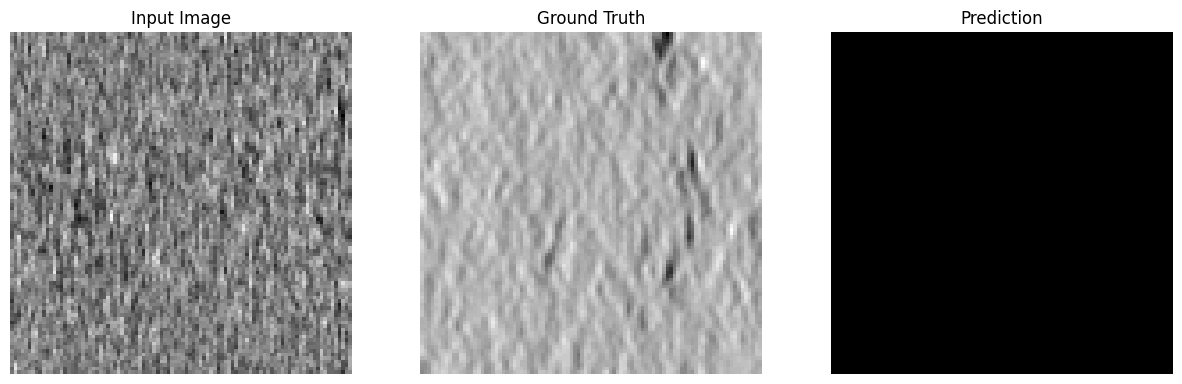

Unique values in predictions: [0]


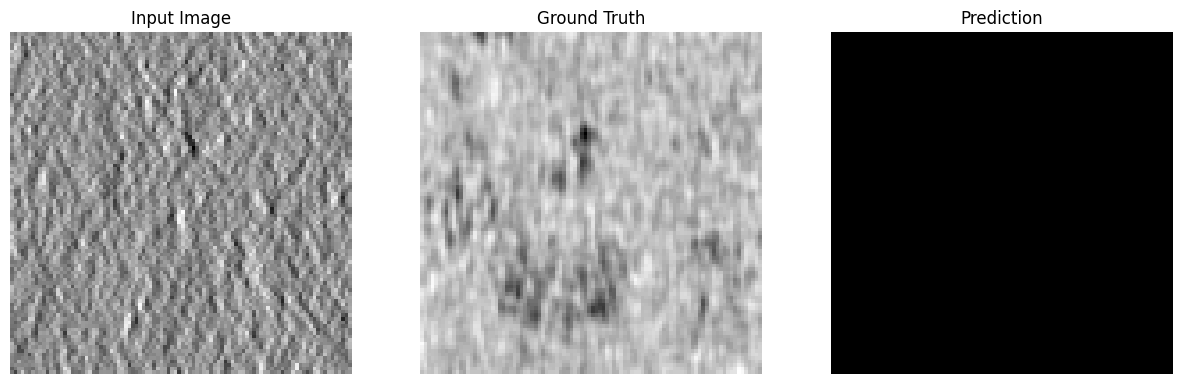

Unique values in predictions: [0]


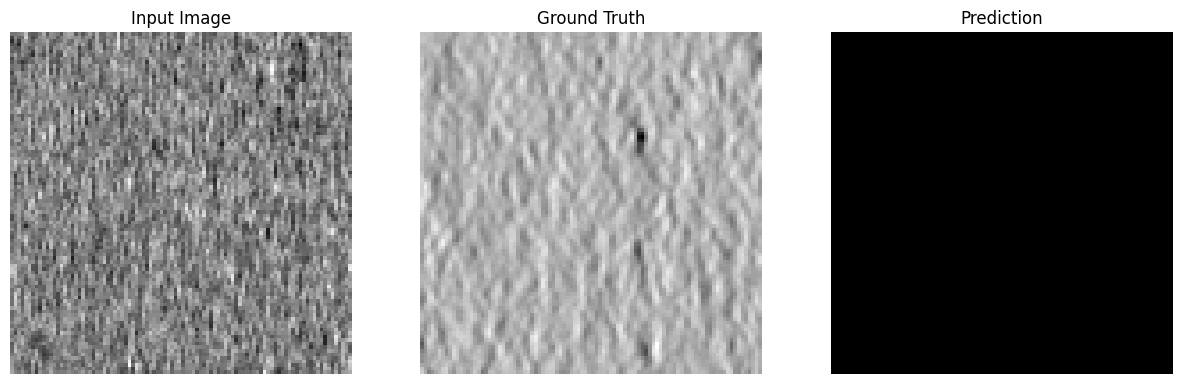

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 최적의 모델 불러오기
def load_best_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# 예측 결과와 실제 라벨 시각화 함수
def visualize_predictions(model, val_loader, device, num_images=5):
    model.eval()
    images, labels, preds = [], [], []
    
    with torch.no_grad():
        for batch_data in tqdm(val_loader, desc='Visualizing'):
            image = batch_data['image'].to(device)
            label = batch_data['label'].to(device)
            
            output = model(image)
            pred = output.argmax(dim=1, keepdim=True)
            
            images.append(image.cpu().numpy())
            labels.append(label.cpu().numpy())
            preds.append(pred.cpu().numpy())
            
            if len(images) >= num_images:
                break
    
    # 시각화
    for i in range(num_images):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(images[i][0, 0, :, :, 48], cmap='gray')
        axes[0].set_title('Input Image')
        axes[0].axis('off')
        
        axes[1].imshow(labels[i][0, 0, :, 48], cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        
        # 예측 값 확인
        print("Unique values in predictions:", np.unique(preds[i]))
        
        # 데이터 범위 설정
        axes[2].imshow(preds[i][0, 0, :, 48], cmap='gray', vmin=0, vmax=1)
        axes[2].set_title('Prediction')
        axes[2].axis('off')
        
        plt.show()

# 모델 학습 후 최적의 모델 불러오기 및 시각화
model = model  # 모델 정의
val_loader = val_loader  # 검증 데이터 로더
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = os.path.join(checkpoint_dir, 'best_model.pt')  # 저장된 최적의 모델 경로

# 최적의 모델 불러오기
if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint= None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

# 예측 결과와 실제 라벨 시각화
visualize_predictions(model, val_loader, device, num_images=3)

In [13]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)

# VAl

In [ ]:
from monai.data import DataLoader, Dataset, CacheDataset
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    Orientationd, CropForegroundd, GaussianSmoothd, ScaleIntensityd,
    RandSpatialCropd, RandRotate90d, RandFlipd, RandGaussianNoised,
    ToTensord, RandCropByLabelClassesd
)
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, SwinUNETR
from monai.losses import TverskyLoss
import torch
import numpy as np
from tqdm import tqdm
import wandb
from src.dataset.dataset import make_val_dataloader

val_img_dir = "./datasets/val/images"
val_label_dir = "./datasets/val/labels"
img_depth = 96
img_size = 96  # Match your patch size
n_classes = 7
batch_size = 2 # 13.8GB GPU memory required for 128x128 img size
num_samples = batch_size # 한 이미지에서 뽑을 샘플 수
loader_batch = 1
lamda = 0.52

wandb.init(
    project='czii_SwinUnetR_val',  # 프로젝트 이름 설정
    name='SwinUNETR96_96_lr0.001_lambda0.52_batch2',         # 실행(run) 이름 설정
    config={
        'learning_rate': 0.001,
        'batch_size': batch_size,
        'lambda': lamda,
        'img_size': img_size,
        'device': 'cuda',
        "checkpoint_dir": "./model_checkpoints/SwinUNETR96_96_lr0.001_lambda0.52_batch2",
        
    }
)

non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    GaussianSmoothd(
        keys=["image"],      # 변환을 적용할 키
        sigma=[1.0, 1.0, 1.0]  # 각 축(x, y, z)의 시그마 값
        ),
])
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[img_depth, img_size, img_size],
        num_classes=n_classes,
        num_samples=num_samples, 
        ratios=ratios_list,
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
])

val_loader = make_val_dataloader(
    val_img_dir, 
    val_label_dir, 
    non_random_transforms = non_random_transforms, 
    random_transforms = random_transforms, 
    batch_size = loader_batch,
    num_workers=0
)
criterion = TverskyLoss(
    alpha= 1 - lamda,  # FP에 대한 가중치
    beta=lamda,       # FN에 대한 가중치
    include_background=False,  # 배경 클래스 제외
    softmax=True
)
    
    
from monai.metrics import DiceMetric

img_size = 96
img_depth = img_size
n_classes = 7 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrain_path = "./model_checkpoints/SwinUNETR96_96_lr0.001_lambda0.52_batch2/best_model.pt"
model = SwinUNETR(
    img_size=(img_depth, img_size, img_size),
    in_channels=1,
    out_channels=n_classes,
    feature_size=48,
    use_checkpoint=True,
).to(device)
# Pretrained weights 불러오기
checkpoint = torch.load(pretrain_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

val_loss, overall_mean_fbeta_score = validate_one_epoch(
    model=model, 
    val_loader=val_loader, 
    criterion=criterion, 
    device=device, 
    epoch=0, 
    calculate_dice_interval=1
)

class_0_dice_score,▁
class_0_f_beta_score,▁
class_1_dice_score,▁
class_1_f_beta_score,▁
class_2_dice_score,▁
class_2_f_beta_score,▁
class_3_dice_score,▁
class_3_f_beta_score,▁
class_4_dice_score,▁
class_4_f_beta_score,▁
class_5_dice_score,▁


Loading dataset: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]
C:\Users\Seungwoo\AppData\Local\Temp\ipykernel_21000\1177025787.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

Validation Dice Score
Class 0: 0.6570, Class 1: 0.5333, Class 2: 0.0029, Class 3: 0.2370, 
Class 4: 0.6549, Class 5: 0.4790, Class 6: 0.4255, 
Validation F-beta Score
Class 0: 0.5075, Class 1: 0.6470, Class 2: 0.0233, Class 3: 0.2303, 
Class 4: 0.6252, Class 5: 0.5145, Class 6: 0.4720, 
Overall Mean Dice Score: 0.4659
Overall Mean F-beta Score: 0.4978



# Inference

In [ ]:
from src.dataset.preprocessing import Preprocessor

In [ ]:
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, EnsureChannelFirstd, NormalizeIntensityd, Orientationd, GaussianSmoothd
from monai.data import DataLoader, Dataset, CacheDataset
from monai.networks.nets import SwinUNETR
from pathlib import Path
import numpy as np
import copick

import torch
print("Done.")

Done.


In [ ]:
config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
          "name" : "beta-amylase",
            "is_particle": true,
            "pdb_id": "8ZRZ",
            "label": 2,
            "color": [255, 255, 255, 128],
            "radius": 90,
            "map_threshold": 0.0578  
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "./kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "./kaggle/input/czii-cryo-et-object-identification/test/static"
}"""

copick_config_path = "./kaggle/working/copick.config"
preprocessor = Preprocessor(config_blob,copick_config_path=copick_config_path)
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS"),
    GaussianSmoothd(
        keys=["image"],      # 변환을 적용할 키
        sigma=[1.0, 1.0, 1.0]  # 각 축(x, y, z)의 시그마 값
        ),
    ])

Config file written to ./kaggle/working/copick.config
file length: 7


In [ ]:
img_size = 96
img_depth = img_size
n_classes = 7 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrain_path = "./model_checkpoints/SwinUNETR96_96_lr0.001_lambda0.52_batch2/best_model.pt"
model = SwinUNETR(
    img_size=(img_depth, img_size, img_size),
    in_channels=1,
    out_channels=n_classes,
    feature_size=48,
    use_checkpoint=True,
).to(device)
# Pretrained weights 불러오기
checkpoint = torch.load(pretrain_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])


c:\ProgramData\anaconda3\envs\ship\Lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
C:\Users\Seungwoo\AppData\Local\Temp\ipykernel_6248\2937359115.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will

<All keys matched successfully>

In [ ]:
val_loss = validate_one_epoch(
            model=model, 
            val_loader=val_loader, 
            criterion=criterion, 
            device=device, 
            epoch=1, 
            calculate_dice_interval=0
        )

Validation:   0%|          | 0/4 [00:03<?, ?it/s, loss=0.764]


ZeroDivisionError: integer modulo by zero

In [ ]:
import torch
import numpy as np
from scipy.ndimage import label, center_of_mass
import pandas as pd
from tqdm import tqdm
from monai.data import CacheDataset, DataLoader
from monai.transforms import Compose, NormalizeIntensity
import cc3d

def dict_to_df(coord_dict, experiment_name):
    all_coords = []
    all_labels = []
    
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    all_coords = np.vstack(all_coords)
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })
    return df

id_to_name = {1: "apo-ferritin", 
              2: "beta-amylase",
              3: "beta-galactosidase", 
              4: "ribosome", 
              5: "thyroglobulin", 
              6: "virus-like-particle"}
BLOB_THRESHOLD = 200
CERTAINTY_THRESHOLD = 0.05

classes = [1, 2, 3, 4, 5, 6]

model.eval()
with torch.no_grad():
    location_dfs = []  # DataFrame 리스트로 초기화
    
    for vol_idx, run in enumerate(preprocessor.root.runs):
        print(f"Processing volume {vol_idx + 1}/{len(preprocessor.root.runs)}")
        tomogram = preprocessor.processing(run=run, task="task")
        task_files = [{"image": tomogram}]
        task_ds = CacheDataset(data=task_files, transform=non_random_transforms)
        task_loader = DataLoader(task_ds, batch_size=1, num_workers=0)
        
        for task_data in task_loader:
            images = task_data['image'].to("cuda")
            outputs = sliding_window_inference(
                inputs=images,
                roi_size=(96, 96, 96),  # ROI 크기
                sw_batch_size=4,
                predictor=model.forward,
                overlap=0.1,
                sw_device="cuda",
                device="cpu",
                buffer_steps=1,
                buffer_dim=-1
            )
            outputs = outputs.argmax(dim=1).squeeze(0).cpu().numpy()  # 클래스 채널 예측
            location = {}  # 좌표 저장용 딕셔너리
            for c in classes:
                cc = cc3d.connected_components(outputs == c)  # cc3d 라벨링
                stats = cc3d.statistics(cc)
                zyx = stats['centroids'][1:] * 10.012444  # 스케일 변환
                zyx_large = zyx[stats['voxel_counts'][1:] > BLOB_THRESHOLD]  # 크기 필터링
                xyz = np.ascontiguousarray(zyx_large[:, ::-1])  # 좌표 스왑 (z, y, x -> x, y, z)

                location[id_to_name[c]] = xyz  # ID 이름 매칭 저장

            # 데이터프레임 변환
            df = dict_to_df(location, run.name)
            location_dfs.append(df)  # 리스트에 추가
        
        # if vol_idx == 2:
        #     break
    
    # DataFrame 병합
    final_df = pd.concat(location_dfs, ignore_index=True)
    
    # ID 추가 및 CSV 저장
    final_df.insert(loc=0, column='id', value=np.arange(len(final_df)))
    final_df.to_csv("submission.csv", index=False)
    print("Submission saved to: submission.csv")


Processing volume 1/7


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Processing volume 2/7


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Processing volume 3/7


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Submission saved to: submission.csv
